In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from util.gaze import draw_gaze
import util.gaze
from scipy.spatial.transform import Rotation as R


## Let's take look at the first image
These images are generated from UnityEyes. Each image is a .jpg file and comes with a .json file of metadata. The json file contains locations of all the eye landmark positions withing the image. 

In [2]:
img1_path = './datasets/UnityEyes/imgs/3.jpg'
img1 = cv2.imread(img1_path)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)


(600, 800, 3)

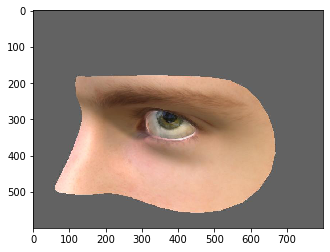

In [3]:
plt.imshow(img1)
img1.shape

## Image Json Data

In [4]:
import json

with open('./datasets/UnityEyes/imgs/3.json') as json_file:
    json_data = json.load(json_file)
print(json.dumps(json_data, indent=2))

{
  "interior_margin_2d": [
    "(312.7325, 282.9888, 9.7947)",
    "(311.2485, 301.0775, 9.7833)",
    "(319.9195, 314.4633, 9.4802)",
    "(337.9854, 323.3019, 9.1831)",
    "(367.9517, 320.6808, 8.8111)",
    "(404.6841, 305.9804, 8.7447)",
    "(429.1161, 292.4188, 8.8657)",
    "(443.1143, 279.0277, 8.9808)",
    "(450.3929, 268.7822, 9.0929)",
    "(441.0293, 259.1880, 9.0769)",
    "(428.4157, 254.0677, 9.0362)",
    "(403.3621, 247.1422, 9.0259)",
    "(370.2010, 247.0631, 9.1104)",
    "(342.9549, 252.9732, 9.3102)",
    "(324.0576, 260.3954, 9.6214)",
    "(316.9303, 266.3593, 9.8603)"
  ],
  "caruncle_2d": [
    "(308.5059, 267.3830, 10.0239)",
    "(306.1961, 276.7448, 10.0069)",
    "(306.6841, 290.3666, 9.9531)",
    "(296.3676, 278.4193, 10.0012)",
    "(297.7841, 273.1226, 10.0177)",
    "(295.2662, 268.3332, 10.0122)",
    "(294.2726, 271.3791, 9.9992)"
  ],
  "iris_2d": [
    "(341.0341, 313.9893, 9.1124)",
    "(342.7548, 321.6234, 9.1196)",
    "(345.8833, 328.8160,

32


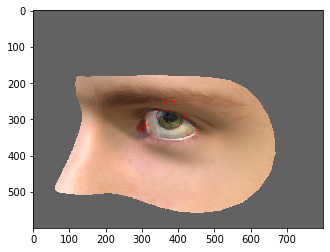

In [5]:
ih, iw = img1.shape[:2]
iw_2, ih_2 = 0.5 * iw, 0.5 * ih

def process_coords(coords_list):
    coords = [eval(l) for l in coords_list]
    return np.array([(x, ih-y, z) for (x, y, z) in coords])
interior_landmarks = process_coords(json_data['interior_margin_2d'])
caruncle_landmarks = process_coords(json_data['caruncle_2d'])
iris_landmarks = process_coords(json_data['iris_2d'])

landmarks_img = img1.copy()
print(len(iris_landmarks))
for (x, y, z) in interior_landmarks:
    landmarks_img = cv2.circle(landmarks_img, (int(x), int(y)), 1, color=(255, 0, 0), thickness=-1)
for (x, y, z) in caruncle_landmarks:
    landmarks_img = cv2.circle(landmarks_img, (int(x), int(y)), 1, color=(255, 0, 0), thickness=-1)
for (x, y, z) in iris_landmarks:
    landmarks_img = cv2.circle(landmarks_img, (int(x), int(y)), 1, color=(255, 0, 0), thickness=-1)
plt.imshow(landmarks_img)
    

### Get the eye middle and corner locations and eye width

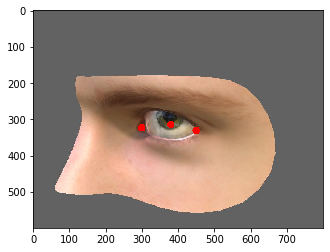

In [6]:
# Prepare to segment eye image
left_corner = np.mean(caruncle_landmarks[:, :2], axis=0)
right_corner = interior_landmarks[8, :2]
eye_width = 1.5 * abs(left_corner[0] - right_corner[0])
eye_middle = np.mean([np.amin(interior_landmarks[:, :2], axis=0),
                      np.amax(interior_landmarks[:, :2], axis=0)], axis=0)

lc = [int(x) for x in left_corner]
rc = [int(x) for x in right_corner]
em = [int(x) for x in eye_middle]
landmarks_img = img1.copy()
landmarks_img = cv2.circle(landmarks_img, tuple(lc), 10, color=(255, 0, 0), thickness=-1)
landmarks_img = cv2.circle(landmarks_img, tuple(rc), 10, color=(255, 0, 0), thickness=-1)
landmarks_img = cv2.circle(landmarks_img, tuple(em), 10, color=(255, 0, 0), thickness=-1)
plt.imshow(landmarks_img)

## Great! Now we'll cut out a sub-image centered on the eye middle. 
We want the the output image to be `90x150` pixels and have a width equal to the eye width. The affine transform will first scale the image so that the eye width equals 150 pixels. Then it centers on the eye middle and crops to `90x150` pixels.

[379.3913125 289.8631625]
[-0.12296454 -0.26201126]
(90, 150, 3)


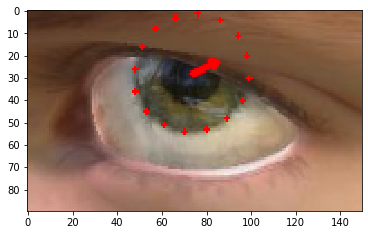

In [19]:
# Re-center so that eye-middle is at the center of the image
def preprocess_unityeyes_image(img, json_data, oh=90, ow=150):
    # Prepare to segment eye image
    
    def process_coords(coords_list):
        coords = [eval(l) for l in coords_list]
        return np.array([(x, ih-y, z) for (x, y, z) in coords])
    
    interior_landmarks = process_coords(json_data['interior_margin_2d'])
    caruncle_landmarks = process_coords(json_data['caruncle_2d'])
    iris_landmarks = process_coords(json_data['iris_2d'])

    left_corner = np.mean(caruncle_landmarks[:, :2], axis=0)
    right_corner = interior_landmarks[8, :2]
    eye_width = 1.5 * abs(left_corner[0] - right_corner[0])
    eye_middle = np.mean([np.amin(interior_landmarks[:, :2], axis=0),
                          np.amax(interior_landmarks[:, :2], axis=0)], axis=0)

    # Normalize to eye width.
    scale = ow/eye_width

    translate = np.asmatrix(np.eye(3))
    translate[0, 2] = -eye_middle[0] * scale
    translate[1, 2] = -eye_middle[1] * scale

    recenter = np.asmatrix(np.eye(3))
    recenter[0, 2] = ow/2
    recenter[1, 2] = oh/2

    scale_mat = np.asmatrix(np.eye(3))
    scale_mat[0, 0] = scale
    scale_mat[1, 1] = scale

    angle = np.random.normal(0, 1) * 20 * np.pi/180
    rotation = R.from_rotvec([0, 0, angle]).as_matrix()

    transform = recenter * rotation * translate * scale_mat
    transform_inv = np.linalg.inv(transform)
    
    # Apply transforms
    eye = cv2.warpAffine(img, transform[:2], (ow, oh))

    # Normalize eye image

    # Gaze
    # Convert look vector to gaze direction in polar angles
    look_vec = np.array(eval(json_data['eye_details']['look_vec']))[:3].reshape((1, 3))
    look_vec = np.matmul(look_vec, rotation)

    gaze = util.gaze.vector_to_pitchyaw(-look_vec).flatten()
    gaze = gaze.astype(np.float32)

    eye = cv2.GaussianBlur(eye, (5,5), 0.001)
    return {
        'img': eye,
        'transform': transform,
        'transform_inv': transform_inv,
        'eye_middle': eye_middle,
        'gaze': gaze
    }

eye_entry = preprocess_unityeyes_image(img1, json_data)

eye_img = eye_entry['img'].copy()
transform = eye_entry['transform']

iris_center = np.mean(iris_landmarks, axis=0)[:2]


landmarks = np.concatenate([interior_landmarks[:, :2],  # 8
                            iris_landmarks[::2, :2],  # 8
                            iris_center.reshape((1, 2)),
                            [[iw_2, ih_2]],  # Eyeball center
                            ])  # 18 in total

landmarks = np.asmatrix(np.pad(landmarks, ((0, 0), (0, 1)), 'constant', constant_values=1))
landmarks = np.asarray(landmarks * transform[:2].T)
landmarks = landmarks.astype(np.float32)

for (x, y) in landmarks[16:32]:
    eye_img = cv2.circle(eye_img, (int(x), int(y)), 1, color=(255, 0, 0), thickness=-1)
    
# for (x, y, z) in interior_landmarks:
#     x, y, _ = np.matmul(transform, [x, y, 1.0])
#     eye_img = cv2.circle(eye_img, (int(x), int(y)), 1, color=(0, 255, 0), thickness=-1)
    
# for (x, y, z) in caruncle_landmarks:
#     x, y, _ = np.matmul(transform, [x, y, 1.0])
#     eye_img = cv2.circle(eye_img, (int(x), int(y)), 1, color=(0, 0, 255), thickness=-1)

print(iris_center)
# eye_img = draw_gaze(eye_img, landmarks[-2], (0, 0), color=(0, 255, 0))
# eye_img = draw_gaze(eye_img, landmarks[-2], (np.pi/2, 0))
# eye_img = draw_gaze(eye_img, landmarks[-2], (0, np.pi/2), color=(255, 0, 0))
eye_img = draw_gaze(eye_img, landmarks[-2], eye_entry['gaze'], color=(255, 0, 0))

gaze = eye_entry['gaze']
print(gaze)
plt.imshow(eye_img)
print(eye_entry['img'].shape)

## Heatmaps
The next thing we need before we can start training is ground truth heatmaps for the model to compare its outputs against. We need one heatmap per iris landmark (32 heatmaps). Each heatmap will have the same dimensions as the input image, but only 1 channel. 

Heat maps are created.

In [8]:
def get_heatmaps(shape, json_data, transform):
    def process_coords(coords_list):
        coords = [eval(l) for l in coords_list]
        return np.array([(x, ih-y, z) for (x, y, z) in coords])
    iris_landmarks = process_coords(json_data['iris_2d'])    
    
    def gaussian_2d(shape, center, sigma=1.0):
        """Generate heatmap with single 2D gaussian."""
        xs = np.arange(0.5, shape[1] + 0.5, step=1.0, dtype=np.float32)
        ys = np.expand_dims(np.arange(0.5, shape[0] + 0.5, step=1.0, dtype=np.float32), -1)
        alpha = -0.5 / (sigma**2)
        heatmap = np.exp(alpha * ((xs - center[0])**2 + (ys - center[1])**2))
        return heatmap

    heatmaps = []
    for (x, y, z) in iris_landmarks:
        x, y = np.matmul(transform, [x, y, 1.0])
        heatmaps.append(gaussian_2d(shape, (int(x), int(y)), sigma=5.0))
    return heatmaps
    

In [9]:
heatmaps = get_heatmaps((90,150), json_data, transform)
merged_heatmaps = np.mean(heatmaps, axis=0)
plt.imshow(merged_heatmaps * 255)

ValueError: not enough values to unpack (expected 2, got 1)